In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/MyDrive/Colab Notebooks/gazeta.zip" -d /content/dataset/

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import torch

In [ ]:
from datasets import Dataset, DatasetDict

dataset_train = Dataset.from_json("/content/dataset/gazeta_train.jsonl")
dataset_test = Dataset.from_json("/content/dataset/gazeta_test.jsonl")
dataset_val = Dataset.from_json("/content/dataset/gazeta_val.jsonl")

russian_dataset = DatasetDict({"train": dataset_train, "validation": dataset_val, "test": dataset_test })
russian_dataset

In [ ]:
from datasets import load_dataset

english_dataset = load_dataset('cnn_dailymail', '1.0.0')
english_dataset

In [ ]:
english_dataset = english_dataset.rename_columns({'article': 'text', 'highlights': 'summary'})
english_dataset = english_dataset.remove_columns("id")
english_dataset

In [ ]:
russian_dataset = russian_dataset.remove_columns(['date', 'url', 'title',])
russian_dataset

In [ ]:
from datasets import concatenate_datasets

dataset = DatasetDict()

def concat_and_slice(split, size):
  dataset[split] = concatenate_datasets(
        [russian_dataset[split].select(range(0,size)), english_dataset[split].select(range(0,size))]
    ).shuffle(seed=100)


concat_and_slice('train', 15000)
concat_and_slice('validation', 2000)
concat_and_slice('test', 2000)

dataset

In [ ]:
def show_samples(dataset, num_samples=3, seed=125):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\nSummary: '{example['summary']}'")
        print(f"Text: '{example['text']}'")

show_samples(dataset)


Summary: 'Web site estimates English got its millionth word at 5:22 a.m. Wednesday . English accumulates new words from other languages and from its global reach . Linguists question group's formula, which estimates rate of new words . English has more words than any other language, site says .'
Text: '(CNN) -- English contains more words than any other language on the planet and added its millionth word early Wednesday, according to the Global Language Monitor, a Web site that uses a math formula to estimate how often words are created. The Global Language Monitor says the millionth word was added to English on Wednesday. The site estimates the millionth English word, "Web 2.0" was added to the language Wednesday at 5:22 a.m. ET. The term refers to the second, more social generation of the Internet. The site says more than 14 words are added to English every day, at the current rate. The "Million Word March," however, has made the man who runs this word-counting project somewhat of a

In [ ]:
from transformers import AutoTokenizer

model_name = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
max_input_length = 512
max_target_length = 256

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
})

In [ ]:
!pip install pandas matplotlib seaborn datasets

In [ ]:
dataset = tokenized_dataset

# Convert the dataset to a DataFrame for easier manipulation
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Combine the dataframes for overall analysis if needed
combined_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)

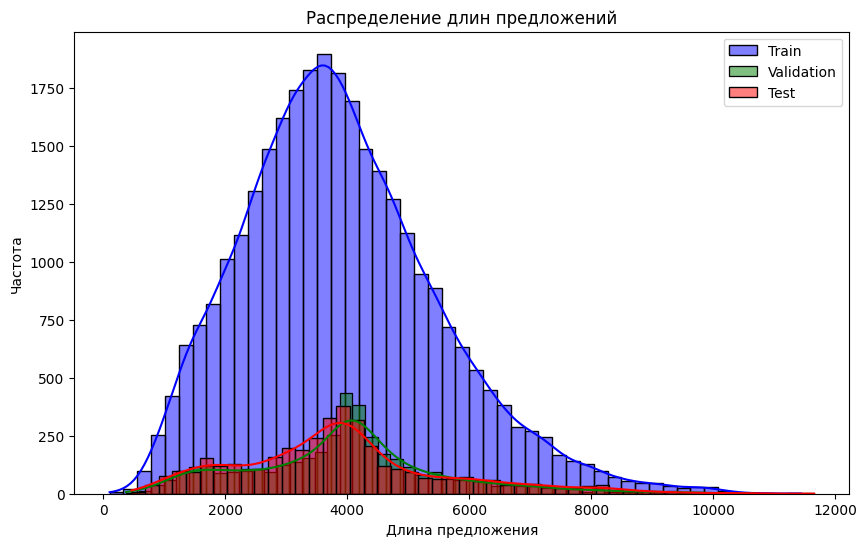

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text'].apply(len), bins=50, kde=True, color='blue', label='Train')
sns.histplot(validation_df['text'].apply(len), bins=50, kde=True, color='green', label='Validation')
sns.histplot(test_df['text'].apply(len), bins=50, kde=True, color='red', label='Test')
plt.xlabel('Длина предложения')
plt.ylabel('Частота')
plt.title('Распределение длин предложений')
plt.legend()
plt.show()

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
clean_tokenized_dataset = tokenized_dataset.remove_columns(
    dataset["train"].column_names
)

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    clean_tokenized_dataset["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)
tf_eval_dataset = model.prepare_tf_dataset(
    clean_tokenized_dataset["validation"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8,
)

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

num_train_epochs = 8
num_train_steps = len(tf_train_dataset) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(
    output_dir=f"mt5-summarizer-3", tokenizer=tokenizer
)

model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset, callbacks=[callback], epochs=num_train_epochs
)

# Использование

In [ ]:
! pip install datasets evaluate transformers rouge-score nltk

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("avaimon/mt5-summarizer")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("avaimon/mt5-summarizer", from_tf=True)

In [ ]:
!pip install evaluate

In [ ]:
import nltk
import numpy as np
from evaluate import load

metric = load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("summarization", model="avaimon/mt5-summarizer")

In [ ]:
idx = 123
text = "На этих выходных в Берлине прошли крупные акции протеста против введенных для борьбы с коронавирусом ограничений. Демонстранты скандировали «Путин!» По словам депутата городской палаты представителей Гуннара Линдеманна («Альтернатива для Германии»), люди выкрикивали фамилию российского президента из уважения к нему. В комментарии РИА «Новости» немецкий политик отметил, что среди населения Германии Владимир Путин имеет хорошую репутацию. По его мнению, протестующие ранее пришли к российскому посольству, чтобы «привлечь внимание к условиям в Германии», надеясь, что Россия сможет оказать влияние на канцлера ФРГ Ангелу Меркель. «На мой взгляд, опасности для посольства России не возникло ни разу», — сказал депутат. Несмотря на то что протест оказался массовым, выступления носили «преимущественно мирный характер», уверен Линдеманн. По его словам, исключением стала только ситуацию у немецкого парламента. Там «несколько странных участников демонстрации попытались штурмовать бундестаг в знак протеста против правительства». Но и здесь, как считает политик, «реальной опасности не было». «Полиция не всегда реагировала соразмерно. Стали известны случаи чрезмерного насилия со стороны полиции, с которыми мы будем разбираться на парламентском уровне в берлинской палате представителей», — отметил он. В эти выходные — 29 и 30 августа — в Берлине прошли массовые акции протеста против антикоронавирусных мер: ношения масок и соблюдения безопасного расстояния в 1,5 м друг от друга. Манифестанты требуют ослабить или отменить ограничения. По данным таблоида Bild, в марше приняли участие около 30 тыс. человек. По официальным данным, манифестантов было почти в два раза меньше — 18 тыс. Протестующие начали собираться в субботу с самого утра на улице Унтер-ден-Линден. После этого они прошли маршем через центр Берлина. Финальной точкой должна была стать Улица 17-июня рядом с Брандербургскими воротами. Из-за акции протеста полиции пришлось ограничить движение по улицам Унтер-ден-Линден, Фридрихштрассе. В частности, было перекрыто пространство вокруг Бранденбургских ворот, а также Александерплац и Лейпцигерплац. Российское посольство находится по улице Унтер-ден-Линден. Именно там произошли стычки протестующих с полицией. Там же собравшиеся начали скандировать фамилию российского президента. При этом участники манифестации забрасывали полицейских бутылками и камнями. По словам представителя берлинской полиции, действия демонстрантов не были направлены против дипмиссии. «У произошедшего не было политических мотивов. На улице Унтер ден Линден находилась группа примерно в две тысячи человек, из которой в полицию бросали бутылки и камни. Два человека задержаны», — рассказала она в комментарии РИА «Новости». Позднее сенатор Берлина по вопросам внутренней политики Андреас Гайзель в прямом эфире Inforadio отметил, что часть полицейских была направлена именно к посольству России, из-за чего была ослаблена охрана бундестага. Как следствие, протестующие его чуть не захватили. «Исходили из того, что парламент, естественно, должен быть защищен. Но на улице Унтер-ден-Линден, почти перед российским посольством были насильственные действия, там кидали бутылки и камни, были раненые, задержано более 200 человек — там было необходимо полицейское подкрепление, и произошла переброска сил. Это длилось несколько минут. Это еще нуждается в оценке», — заявил сенатор. Ранее ТАСС сообщал, что всего за порядком наблюдали порядка 3 тыс. правоохранителей. Причем 1 тыс. служащих были направлены из других федеральных земель. В правоохранительных органах отмечали, что «безуспешно призывали» протестующих соблюдать положенные правила. Всего в субботу были задержаны 316 человек. Обвинения были предъявлены 131 демонстранту, 33 полицейских пострадали."
summary = "Протестующие против антикоронавирусных мер немцы скандировали имя российского президента, потому что уважают его. Такое мнение выразил депутат городской палаты представителей Гуннар Линдеманн. На этих выходных в Берлине прошли крупные акции протеста. Манифестанты требовали отменить ношение масок и отказаться от соблюдения безопасного расстояния в 1,5 м друг от друга."
predicted_summary = pipe(text, max_new_tokens=256)[0]["summary_text"]
print(f">>> Text: {text}")
print(f"\n>>> Summary: {summary}")
print(f"\n>>> Predicted Summary: {predicted_summary}")

In [ ]:
en_text = "English contains more words than any other language on the planet and added its millionth word early Wednesday, according to the Global Language Monitor, a Web site that uses a math formula to estimate how often words are created. The Global Language Monitor says the millionth word was added to English on Wednesday. The site estimates the millionth English word, Web 2.0 was added to the language Wednesday at 5:22 a.m. ET. The term refers to the second, more social generation of the Internet. The site says more than 14 words are added to English every day, at the current rate. The Million Word March, however, has made the man who runs this word-counting project somewhat of a pariah in the linguistic community. Some linguists say it's impossible to count the number of words in a language because languages are always changing, and because defining what counts as a word is a fruitless endeavor. Paul J.J. Payack, president and chief word analyst for the Global Language Monitor, says, however, that the million-word estimation isn't as important as the idea behind his project, which is to show that English has become a complex, global language."
en_summary = "The Global Language Monitor announced that English reached its millionth word, Web 2.0, at 5:22 a.m. ET on Wednesday, reflecting the language's vast and dynamic nature. According to the website, which uses a mathematical formula to estimate word creation, over 14 words are added to English daily. However, the project, led by Paul J.J. Payack, faces criticism from linguists who argue that counting words in a language is impractical due to constant changes and challenges in defining what constitutes a word. Despite controversy, Payack emphasizes that the project's significance lies in highlighting English's complexity and global reach."
predicted_en_summary = pipe(en_text)[0]["summary_text"]
print(f">>> Text: {en_text}")
print(f"\n>>> Predicted Summary: {predicted_en_summary}")

In [ ]:
!pip install rouge_score

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
scores = rouge_score.compute(
    predictions=[predicted_summary], references=[summary]
)
scores

In [ ]:
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
scores = scorer.score(summ, orig_summ)

# Print the ROUGE scores
for metric, score in scores.items():
    print(f"{metric}: Precision: {score.precision:.4f}, Recall: {score.recall:.4f}, F1: {score.fmeasure:.4f}.")

# Облегченный вариант

In [ ]:
!pip install fastt5

In [ ]:
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers

In [ ]:
T5_PATH = 't5-small' # T5 model name

# initialize the model architecture and weights

t5_model = T5ForConditionalGeneration.from_pretrained(T5_PATH)

# initialize the model tokenizer

t5_tokenizer = T5Tokenizer.from_pretrained(T5_PATH)

In [ ]:

inputs = tokenizer.encode("summarize: " + en_text, return_tensors="pt", max_length=512, padding='max_length', truncation=True)

summary_ids = t5_model.generate(inputs,
                                    num_beams=int(2),
                                    no_repeat_ngram_size=3,
                                    length_penalty=2.0,
                                    min_length=128,
                                    max_length=128,
                                    early_stopping=True)

output = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
output

In [ ]:
import torch
import json
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

# model = T5ForConditionalGeneration.from_pretrained('google-t5/t5-small')
model_name = 't5-small'
model = export_and_get_onnx_model(model_name)

# tokenizer = T5Tokenizer.from_pretrained('google-t5/t5-small')
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device('cpu')

In [ ]:
text = text = dataset["test"][99]["text"]
preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: " + preprocess_text
print ("original text preprocessed: \n", t5_prepared_Text)

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

In [ ]:
# summmarize
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=128,
                                    max_length=256,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
!pip install optimum[exporters-tf]

In [ ]:
!optimum-cli export tflite --model google-bert/bert-base-uncased --sequence_length 128 bert_tflite/

In [ ]:
from transformers import MT5ForConditionalGeneration, MT5Tokenizer

# Define the model name
model_name = "google/mt5-small"

# Initialize tokenizer and model
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)

# Define local directory paths for model and tokenizer
model_dir = "path_to_model_directory"
tokenizer_dir = "path_to_tokenizer_directory"

# Save the model and tokenizer to local directory
model.save_pretrained(model_dir)
tokenizer.save_pretrained(tokenizer_dir)

print("Model and tokenizer downloaded and saved to local directory.")

# BERT extractive

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def sentencize(text):
  return [sentence.strip() for sentence in nltk.sent_tokenize(text)]

In [ ]:
print(sent_tokenize("Hello there! How are you doing today? This is a sample text."))
print(sent_tokenize("Привет! Как делишки. Ты говоришь по русски?"))

In [ ]:
text_ru = "На этих выходных в Берлине прошли крупные акции протеста против введенных для борьбы с коронавирусом ограничений. Демонстранты скандировали «Путин!» По словам депутата городской палаты представителей Гуннара Линдеманна («Альтернатива для Германии»), люди выкрикивали фамилию российского президента из уважения к нему. В комментарии РИА «Новости» немецкий политик отметил, что среди населения Германии Владимир Путин имеет хорошую репутацию. По его мнению, протестующие ранее пришли к российскому посольству, чтобы «привлечь внимание к условиям в Германии», надеясь, что Россия сможет оказать влияние на канцлера ФРГ Ангелу Меркель. «На мой взгляд, опасности для посольства России не возникло ни разу», — сказал депутат. Несмотря на то что протест оказался массовым, выступления носили «преимущественно мирный характер», уверен Линдеманн. По его словам, исключением стала только ситуацию у немецкого парламента. Там «несколько странных участников демонстрации попытались штурмовать бундестаг в знак протеста против правительства». Но и здесь, как считает политик, «реальной опасности не было». «Полиция не всегда реагировала соразмерно. Стали известны случаи чрезмерного насилия со стороны полиции, с которыми мы будем разбираться на парламентском уровне в берлинской палате представителей», — отметил он. В эти выходные — 29 и 30 августа — в Берлине прошли массовые акции протеста против антикоронавирусных мер: ношения масок и соблюдения безопасного расстояния в 1,5 м друг от друга. Манифестанты требуют ослабить или отменить ограничения. По данным таблоида Bild, в марше приняли участие около 30 тыс. человек. По официальным данным, манифестантов было почти в два раза меньше — 18 тыс. Протестующие начали собираться в субботу с самого утра на улице Унтер-ден-Линден. После этого они прошли маршем через центр Берлина. Финальной точкой должна была стать Улица 17-июня рядом с Брандербургскими воротами. Из-за акции протеста полиции пришлось ограничить движение по улицам Унтер-ден-Линден, Фридрихштрассе. В частности, было перекрыто пространство вокруг Бранденбургских ворот, а также Александерплац и Лейпцигерплац. Российское посольство находится по улице Унтер-ден-Линден. Именно там произошли стычки протестующих с полицией. Там же собравшиеся начали скандировать фамилию российского президента. При этом участники манифестации забрасывали полицейских бутылками и камнями. По словам представителя берлинской полиции, действия демонстрантов не были направлены против дипмиссии. «У произошедшего не было политических мотивов. На улице Унтер ден Линден находилась группа примерно в две тысячи человек, из которой в полицию бросали бутылки и камни. Два человека задержаны», — рассказала она в комментарии РИА «Новости». Позднее сенатор Берлина по вопросам внутренней политики Андреас Гайзель в прямом эфире Inforadio отметил, что часть полицейских была направлена именно к посольству России, из-за чего была ослаблена охрана бундестага. Как следствие, протестующие его чуть не захватили. «Исходили из того, что парламент, естественно, должен быть защищен. Но на улице Унтер-ден-Линден, почти перед российским посольством были насильственные действия, там кидали бутылки и камни, были раненые, задержано более 200 человек — там было необходимо полицейское подкрепление, и произошла переброска сил. Это длилось несколько минут. Это еще нуждается в оценке», — заявил сенатор. Ранее ТАСС сообщал, что всего за порядком наблюдали порядка 3 тыс. правоохранителей. Причем 1 тыс. служащих были направлены из других федеральных земель. В правоохранительных органах отмечали, что «безуспешно призывали» протестующих соблюдать положенные правила. Всего в субботу были задержаны 316 человек. Обвинения были предъявлены 131 демонстранту, 33 полицейских пострадали."
text_en = "English contains more words than any other language on the planet and added its millionth word early Wednesday, according to the Global Language Monitor, a Web site that uses a math formula to estimate how often words are created. The Global Language Monitor says the millionth word was added to English on Wednesday. The site estimates the millionth English word, Web 2.0 was added to the language Wednesday at 5:22 a.m. The term refers to the second, more social generation of the Internet. The site says more than 14 words are added to English every day, at the current rate. The Million Word March, however, has made the man who runs this word-counting project somewhat of a pariah in the linguistic community. Some linguists say it's impossible to count the number of words in a language because languages are always changing, and because defining what counts as a word is a fruitless endeavor. Paul J.J. Payack, president and chief word analyst for the Global Language Monitor, says, however, that the million-word estimation isn't as important as the idea behind his project, which is to show that English has become a complex, global language."

In [ ]:
text_long = "The Moon may be the final frontier for mankind, but what will we eat when we get there? Pasta and protein bars made out of thin air are just the beginning. Space fever is approaching at warp speed. In the next two years, Nasa plans to send astronauts back to the Moon via its Artemis programme; the International Space Station (ISS), designed to orbit for 15 years but now hitting its 26th year in space, will soon be replaced; and scientists are looking seriously into the possibility of manned deep space missions. Add to that a proliferation of tourism projects rocketing deep-pocketed individuals up to the edge of space and it begs one question for a food writer like me: what will we eat when we get there? Food is something that keeps astronauts sane, says Dr Sonja Brungs, astronaut operations deputy lead at the European Space Agency. Good food, proper food with a lot of variety, tailored to the needs of the individual astronauts is crucial for a successful deep space mission. I think people underestimate how important it is. Currently, astronauts are given small food pouches containing prepared meals. These meals are made by specialised food-production companies and then freeze-dried, dehydrated or thermostabilised. Astronauts add water to heat or cool the meals to eat; they can also bring along a special meal that reminds them of home (this too has to be carefully formulated and thermostablised). There are some no-gos: anything that crumbs, like bread, can't be taken into space as the crumbs can easily become airborne in the low-gravity environment, meaning they could be inhaled or get into vital equipment. Salt is limited, due to the fact that the body stores sodium differently in space, leading to accelerated osteoporosis, and alcohol is also not permitted as it affects the waste water recycling system in the ISS. Novelty is definitely an issue, says Brungs. Astronauts who are in space for just six months miss crunchiness and texture. It is really important for mental wellbeing to have a variety of textures, and especially for deep space missions, having a variety of foods to eat. In 2021, Nasa launched a Deep Space Food Challenge to discover new ways to create food in space with limited resources producing minimal waste, while also providing safe, nutritious and tasty food that can perform on a long-term deep space mission. Solar Foods, based in Helsinki, is one of the eight companies that has reached the challenge's final phase. Their remarkable concept: using space waste to create protein. We make food out of thin air, quite literally, says Artuu Luukanen, Solar Foods' senior vice president in Space and Defence. His company discovered an edible microbe in the Finnish countryside that grows by feeding on a mixture of carbon dioxide, hydrogen and oxygen. The result is a source of protein from bacteria. The protein can be blended with a range of flavours or textures to create various kinds of nutritious food, such as pasta, protein bars, alternative meats and even an egg replacement. We started thinking about space food because in any space habitat, you have two key waste gases available: hydrogen and carbon dioxide, Luukanen said. So what we are talking about here is really not just a food manufacturing technology for space, but something that will be an integral part of the environmental control and life support system."

In [ ]:
import pandas as pd

data_ru = pd.DataFrame(sentencize(text_ru), columns = ['sentence'])
data_en = pd.DataFrame(sentencize(text_en), columns = ['sentence'])

data_long = pd.DataFrame(sentencize(text_long), columns = ['sentence'])
data_long

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
def get_sentence_embeddings(sentence):
    return embedding_model.encode([sentence])[0]

# get_sentence_embeddings("English contains more words than any other language.")e

In [ ]:
data_long['embeddings']=data_long['sentence'].apply(get_sentence_embeddings)
# data_ru['embeddings']=data_en['sentence'].apply(get_sentence_embeddings)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

def get_text_clusters(data, n_clusters):
  model = KMeans(n_clusters = n_clusters)
  return model.fit_predict(data), model.cluster_centers_

assigned_clusters, centers = get_text_clusters(np.array(data_long['embeddings'].tolist()), 5)

In [ ]:
data_long['cluster']=pd.Series(assigned_clusters, index=data_long.index)
data_long['centroid']=data_long['cluster'].apply(lambda x: centers[x])
data_long

,sentence,embeddings,cluster,centroid
0,The Moon may be the final frontier for mankind...,"[0.122831464, 0.056791443, -0.021970093, -0.08...",1,"[0.06485335, 0.025011957, -0.012359809, -0.032..."
1,Pasta and protein bars made out of thin air ar...,"[0.017823303, 0.052053384, 0.0042437525, -0.02...",0,"[0.03176187, 0.0029540174, 0.004757678, -0.026..."
2,Space fever is approaching at warp speed.,"[0.041289125, 0.040269922, 0.017955923, -0.068...",4,"[0.063507766, 0.034567617, 0.009426614, -0.062..."
3,"In the next two years, Nasa plans to send astr...","[0.08572641, 0.028865313, 0.0008973057, -0.056...",4,"[0.063507766, 0.034567617, 0.009426614, -0.062..."
4,Add to that a proliferation of tourism project...,"[0.08879637, 0.03583433, -0.008422016, -0.0687...",1,"[0.06485335, 0.025011957, -0.012359809, -0.032..."
5,"Food is something that keeps astronauts sane, ...","[0.05847875, 0.048646543, -0.004814679, -0.007...",1,"[0.06485335, 0.025011957, -0.012359809, -0.032..."
6,"Good food, proper food with a lot of variety, ...","[0.052722055, 0.01962759, -0.013532931, -0.043...",1,"[0.06485335, 0.025011957, -0.012359809, -0.032..."
7,I think people underestimate how important it is.,"[-0.008284432, 0.089556105, -0.00749824, -0.00...",3,"[0.018172298, 0.032715946, -0.007103375, -0.01..."
8,"Currently, astronauts are given small food pou...","[0.053120185, -0.0064414153, -0.007998563, -0....",1,"[0.06485335, 0.025011957, -0.012359809, -0.032..."
9,These meals are made by specialised food-produ...,"[0.02030807, -0.04389323, -0.019658972, 0.0196...",2,"[0.082080305, 0.0047710296, -0.015085189, -0.0..."


In [ ]:
from scipy.spatial import distance_matrix
def distance_from_centroid(row):
    return distance_matrix([row['embeddings']], [row['centroid'].tolist()])[0][0]
data_long['distance_from_centroid'] = data_long.apply(distance_from_centroid, axis=1)
data_long

In [ ]:
embs = np.array(data_long['sentence'].apply(get_sentence_embeddings).tolist())

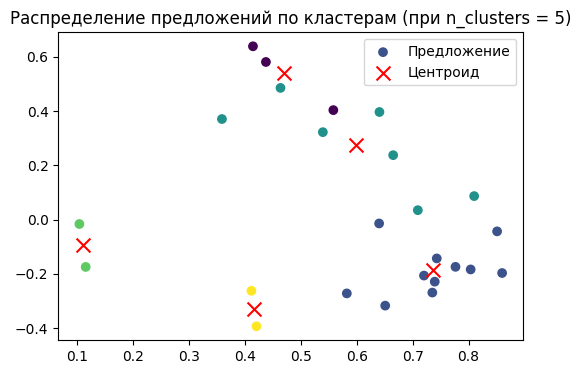

In [ ]:
# Reduce dimensions
svd = TruncatedSVD(n_components=2)
reduced_vectorized_data = svd.fit_transform(embs)

# Calculate centroids
cluster_labels = data_long['cluster']
unique_clusters = np.unique(cluster_labels)
centroids = np.array([reduced_vectorized_data[cluster_labels == cluster].mean(axis=0) for cluster in unique_clusters])

# Plotting
figure(figsize=(6, 4))
plt.scatter(reduced_vectorized_data[:,0], reduced_vectorized_data[:,1], c=cluster_labels, label='Предложение')
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x', s=100, label='Центроид')
plt.title("Распределение предложений по кластерам (при n_clusters = 5)")
plt.legend()
plt.show()

In [ ]:
summary=' '.join(data_long.sort_values('distance_from_centroid',ascending = True).groupby('cluster').head(1).sort_index()['sentence'].tolist())
summary

'Space fever is approaching at warp speed. Good food, proper food with a lot of variety, tailored to the needs of the individual astronauts is crucial for a successful deep space mission. I think people underestimate how important it is. The protein can be blended with a range of flavours or textures to create various kinds of nutritious food, such as pasta, protein bars, alternative meats and even an egg replacement. So what we are talking about here is really not just a food manufacturing technology for space, but something that will be an integral part of the environmental control and life support system.'

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# Example reference and generated summaries
reference_summary = "The quick brown fox jumps over the lazy dog."
generated_summary = "A fast, brown fox leaps over a lazy dog."

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
scores = scorer.score(text_long, summary)

# Print the ROUGE scores
for metric, score in scores.items():
    print(f"{metric}: Precision: {score.precision:.4f}, Recall: {score.recall:.4f}, F1: {score.fmeasure:.4f}.")